# Building Machine Learning Systems with Python - Chapter 11

In this chapter we will create a music genre classifier. While the ML algorithm itself (logistic regression) is nothing fancy by now, we will look into fancy features like Fast Fourier Transforms and Mel Frequency Cepstral Coefficients, use P/R and ROC curves to analyze what works best and then figure out which version to use.

This code is supporting material for the book `Building Machine Learning Systems with Python` by [Willi Richert](https://www.linkedin.com/in/willirichert/), [Luis Pedro Coelho](https://www.linkedin.com/in/luispedrocoelho/) and [Matthieu Brucher](https://www.linkedin.com/in/matthieubrucher/) published by PACKT Publishing. It is made available under the MIT License.

All code examples use Python in version...

In [1]:
import sys
sys.version

'3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 18:21:58) \n[GCC 7.2.0]'

## Utilities we will need

In [2]:
import os
import glob 
from pathlib import Path

CHART_DIR = "charts"
if not Path(CHART_DIR).exists():
    os.mkdir(CHART_DIR)

DATA_DIR = "data"
if not Path(DATA_DIR).exists():
    os.mkdir(DATA_DIR)

GENRE_DIR = Path(DATA_DIR) / 'genres'

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import numpy as np
import scipy

DPI = 100

import collections
import csv

def save_png(name):
    fn = 'B09124_11_%s.png'%name # please ignore, it just helps our publisher :-)
    plt.savefig(str(Path(CHART_DIR) / fn), bbox_inches="tight")
    
    
def plot_pr(auc_score, name, precision, recall, label=None, plot_nr=None):
    plt.figure(num=None, figsize=(5, 4), dpi=DPI)
    plt.grid(True)
    plt.fill_between(recall, precision, alpha=0.5)
    plt.plot(recall, precision, lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R curve (AUC=%0.2f) / %s' % (auc_score, label))
    filename = name.replace(" ", "_")
    save_png("%s_pr_%s" % (plot_nr, filename))
    
def plot_roc(auc_score, name, tpr, fpr, label=None, plot_nr=None):
    plt.figure(num=None, figsize=(5, 4), dpi=DPI)
    plt.grid(True)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.fill_between(fpr, tpr, alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (AUC = %0.2f) / %s' % (auc_score, label), verticalalignment="bottom")
    plt.legend(loc="lower right")
    save_png('%i_auc_%s' % (plot_nr, name))

## Preparing the data

In [3]:
import urllib.request

genre_fn = 'http://opihi.cs.uvic.ca/sound/genres.tar.gz'
urllib.request.urlretrieve(genre_fn, Path(DATA_DIR) / 'genres.tar.gz')

(PosixPath('data/genres.tar.gz'), <http.client.HTTPMessage at 0x7fc6807e0c88>)

In [4]:
import tarfile

cwd = os.getcwd()

os.chdir(DATA_DIR)

try:
    f = tarfile.open('genres.tar.gz', 'r:gz')
    try: 
        f.extractall()
    finally: 
        f.close()
finally:
    os.chdir(cwd)

Download and install https://sourceforge.net/projects/sox/files/sox/. For this notebook, we are using SOX 14.4.2 to convert the downloaded genre files from `.au` into `.wav` format, which is easier to handle.

In [5]:
SOX_PATH = r'C:\Program Files (x86)\sox-14-4-2'
SOX = SOX_PATH + r'\sox.exe'
SOX = "sox"

In [6]:
for au_fn in Path(GENRE_DIR).glob('**/*.au'):
    print(au_fn)
    !"{SOX}" {au_fn} {au_fn.with_suffix('.wav')}

data/genres/reggae/reggae.00006.au
data/genres/reggae/reggae.00076.au
data/genres/reggae/reggae.00028.au
data/genres/reggae/reggae.00039.au
data/genres/reggae/reggae.00005.au
data/genres/reggae/reggae.00050.au
data/genres/reggae/reggae.00085.au
data/genres/reggae/reggae.00054.au
data/genres/reggae/reggae.00038.au
data/genres/reggae/reggae.00058.au
data/genres/reggae/reggae.00007.au
data/genres/reggae/reggae.00087.au
data/genres/reggae/reggae.00010.au
data/genres/reggae/reggae.00016.au
data/genres/reggae/reggae.00080.au
data/genres/reggae/reggae.00047.au
data/genres/reggae/reggae.00009.au
data/genres/reggae/reggae.00053.au
data/genres/reggae/reggae.00063.au
data/genres/reggae/reggae.00096.au
data/genres/reggae/reggae.00095.au
data/genres/reggae/reggae.00033.au
data/genres/reggae/reggae.00044.au
data/genres/reggae/reggae.00045.au
data/genres/reggae/reggae.00094.au
data/genres/reggae/reggae.00019.au
data/genres/reggae/reggae.00073.au
data/genres/reggae/reggae.00060.au
data/genres/reggae/r

data/genres/classical/classical.00082.au
data/genres/classical/classical.00096.au
data/genres/classical/classical.00040.au
data/genres/classical/classical.00071.au
data/genres/classical/classical.00087.au
data/genres/classical/classical.00008.au
data/genres/classical/classical.00033.au
data/genres/classical/classical.00059.au
data/genres/classical/classical.00011.au
data/genres/classical/classical.00022.au
data/genres/classical/classical.00067.au
data/genres/classical/classical.00023.au
data/genres/classical/classical.00097.au
data/genres/classical/classical.00093.au
data/genres/classical/classical.00058.au
data/genres/classical/classical.00056.au
data/genres/classical/classical.00078.au
data/genres/classical/classical.00005.au
data/genres/classical/classical.00086.au
data/genres/classical/classical.00031.au
data/genres/classical/classical.00084.au
data/genres/classical/classical.00032.au
data/genres/classical/classical.00017.au
data/genres/classical/classical.00014.au
data/genres/clas

data/genres/blues/blues.00099.au
data/genres/blues/blues.00097.au
data/genres/blues/blues.00063.au
data/genres/blues/blues.00050.au
data/genres/blues/blues.00075.au
data/genres/blues/blues.00033.au
data/genres/blues/blues.00045.au
data/genres/blues/blues.00082.au
data/genres/blues/blues.00061.au
data/genres/blues/blues.00010.au
data/genres/blues/blues.00051.au
data/genres/blues/blues.00076.au
data/genres/blues/blues.00009.au
data/genres/blues/blues.00035.au
data/genres/blues/blues.00072.au
data/genres/blues/blues.00020.au
data/genres/blues/blues.00005.au
data/genres/blues/blues.00042.au
data/genres/blues/blues.00041.au
data/genres/blues/blues.00081.au
data/genres/blues/blues.00012.au
data/genres/metal/metal.00095.au
data/genres/metal/metal.00015.au
data/genres/metal/metal.00054.au
data/genres/metal/metal.00040.au
data/genres/metal/metal.00010.au
data/genres/metal/metal.00028.au
data/genres/metal/metal.00051.au
data/genres/metal/metal.00059.au
data/genres/metal/metal.00027.au
data/genre

data/genres/rock/rock.00093.au
data/genres/rock/rock.00035.au
data/genres/rock/rock.00097.au
data/genres/rock/rock.00014.au
data/genres/rock/rock.00098.au
data/genres/rock/rock.00059.au
data/genres/rock/rock.00001.au
data/genres/rock/rock.00003.au
data/genres/rock/rock.00091.au
data/genres/rock/rock.00050.au
data/genres/rock/rock.00052.au
data/genres/rock/rock.00047.au
data/genres/rock/rock.00012.au
data/genres/rock/rock.00094.au
data/genres/rock/rock.00082.au
data/genres/rock/rock.00032.au
data/genres/rock/rock.00034.au
data/genres/rock/rock.00020.au
data/genres/rock/rock.00033.au
data/genres/rock/rock.00058.au
data/genres/rock/rock.00096.au
data/genres/rock/rock.00039.au
data/genres/rock/rock.00036.au
data/genres/rock/rock.00010.au
data/genres/rock/rock.00060.au
data/genres/rock/rock.00095.au
data/genres/rock/rock.00006.au
data/genres/rock/rock.00080.au
data/genres/rock/rock.00022.au
data/genres/rock/rock.00089.au
data/genres/rock/rock.00005.au
data/genres/rock/rock.00076.au
data/gen

data/genres/hiphop/hiphop.00077.au
data/genres/hiphop/hiphop.00008.au
data/genres/hiphop/hiphop.00012.au
data/genres/hiphop/hiphop.00017.au
data/genres/hiphop/hiphop.00019.au
data/genres/hiphop/hiphop.00034.au
data/genres/hiphop/hiphop.00095.au
data/genres/hiphop/hiphop.00035.au
data/genres/hiphop/hiphop.00023.au
data/genres/hiphop/hiphop.00054.au
data/genres/hiphop/hiphop.00044.au
data/genres/hiphop/hiphop.00026.au
data/genres/hiphop/hiphop.00039.au
data/genres/hiphop/hiphop.00094.au
data/genres/hiphop/hiphop.00079.au
data/genres/hiphop/hiphop.00036.au
data/genres/hiphop/hiphop.00070.au
data/genres/hiphop/hiphop.00071.au
data/genres/hiphop/hiphop.00045.au
data/genres/hiphop/hiphop.00038.au
data/genres/hiphop/hiphop.00057.au
data/genres/hiphop/hiphop.00004.au
data/genres/hiphop/hiphop.00068.au
data/genres/hiphop/hiphop.00053.au
data/genres/hiphop/hiphop.00041.au
data/genres/hiphop/hiphop.00037.au
data/genres/hiphop/hiphop.00040.au
data/genres/hiphop/hiphop.00018.au


# Looking at music

<Figure size 432x288 with 0 Axes>

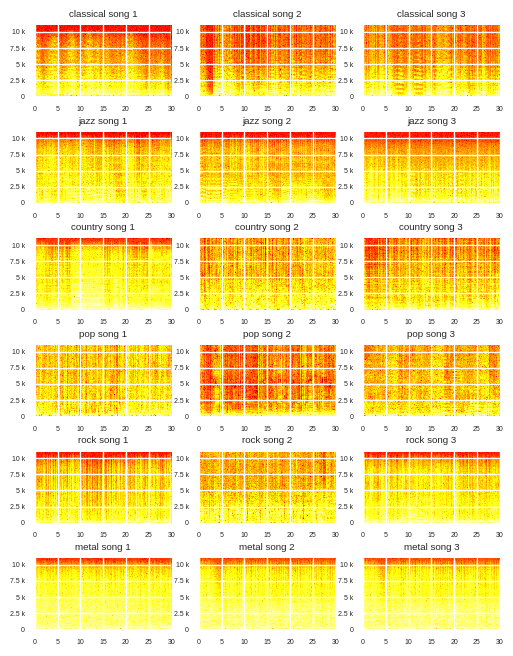

In [7]:
import scipy.io.wavfile

from matplotlib.ticker import EngFormatter

def plot_specgram(ax, fn):
    sample_rate, X = scipy.io.wavfile.read(fn)
    ax.specgram(X, Fs=sample_rate, xextent=(0, 30), cmap='hot')

GENRES = ["classical", "jazz", "country", "pop", "rock", "metal"]

def plot_specgrams():
    """
    Plot a bunch of spectrograms of wav files in different genres
    """
    plt.clf()
    
    num_files = 3
    f, axes = plt.subplots(len(GENRES), num_files, dpi=DPI, figsize=(6, 8))
    
    for genre_idx, genre in enumerate(GENRES):
        for idx, fn in enumerate((Path(GENRE_DIR) / genre).glob('*.wav')):
            if idx == num_files:
                break
            
            axis = axes[genre_idx, idx]
            axis.tick_params(direction='out', length=0, width=1, labelsize=5)
    
            axis.yaxis.set_major_formatter(EngFormatter())
            axis.set_title("%s song %i" % (genre, idx + 1), fontsize=7)
            plot_specgram(axis, fn)
        
    plt.subplots_adjust(hspace=0.5)
    save_png("5_Spectrogram_Genres")
    
plot_specgrams()

# Playing with waves

In [8]:
!"{SOX}" --null -r 22050 sine_a.wav synth 0.2 sine 400

In [9]:
!"{SOX}" --null -r 22050 sine_b.wav synth 0.2 sine 3000

In [10]:
!"{SOX}" --combine mix --volume 1 sine_b.wav --volume 0.5 sine_a.wav sine_mix.wav

C:\Program Files (x86)\sox-14-4-2\sox.exe WARN sox: mix-combining clipped 140 samples; decrease volume?


Now we have three files `sine_a.wav`, `sine_b.wav`, `sine_mix.wav` in the current directory, which we can visualize.

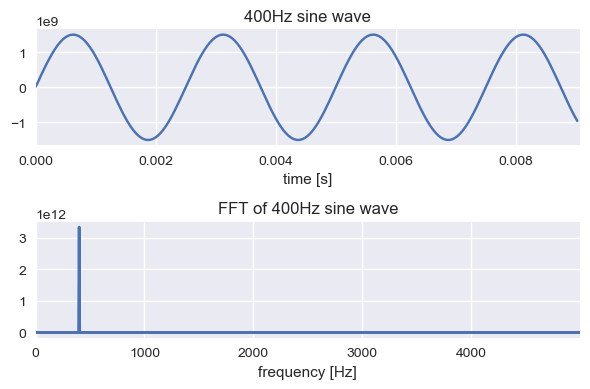

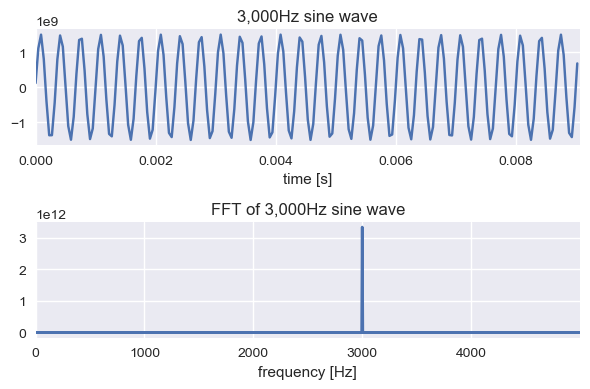

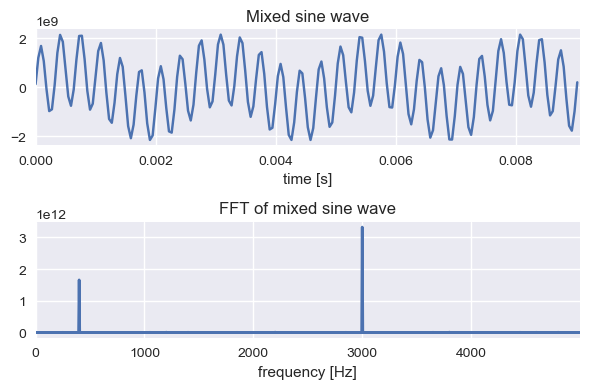

In [11]:
import scipy

def plot_wav_fft(wav_filename, desc=None, plot=0):
    plt.clf()
    plt.figure(num=None, figsize=(6, 4), dpi=DPI)
    sample_rate, X = scipy.io.wavfile.read(wav_filename)
    spectrum = np.fft.fft(X)
    freq = np.fft.fftfreq(len(X), 1.0 / sample_rate)

    plt.subplot(211)
    num_samples = 200
    plt.xlim(0, num_samples / sample_rate)
    plt.xlabel("time [s]")
    plt.title(desc or wav_filename)
    plt.plot(np.arange(num_samples) / sample_rate, X[:num_samples])
    plt.grid(True)

    plt.subplot(212)
    plt.xlim(0, 5000)
    plt.xlabel("frequency [Hz]")
    plt.xticks(np.arange(5) * 1000)
    if desc:
        desc = desc.strip()
        fft_desc = desc[0].lower() + desc[1:]
    else:
        fft_desc = wav_filename
    plt.title("FFT of %s" % fft_desc)
    plt.plot(freq, abs(spectrum), linewidth=2)
    plt.grid(True)

    plt.tight_layout()

    rel_filename = os.path.split(wav_filename)[1]
    save_png("%i_%s_wav_fft" % (plot, os.path.splitext(rel_filename)[0]))

    plt.show()


plot_wav_fft("sine_a.wav", "400Hz sine wave", 1)
plot_wav_fft("sine_b.wav", "3,000Hz sine wave", 2)
plot_wav_fft("sine_mix.wav", "Mixed sine wave", 3)

A "real" music file looks a bit noisier:

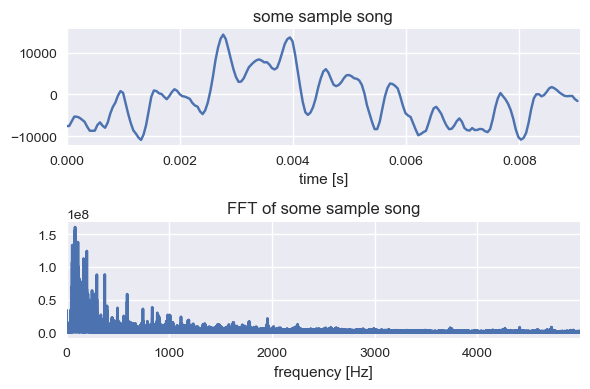

In [12]:
plot_wav_fft(Path(GENRE_DIR) / 'disco' / 'disco.00000.wav', "some sample song", 4)

# First classifier using FFT

## Generating FFT features

In [13]:
def create_fft(fn):
    sample_rate, X = scipy.io.wavfile.read(fn)

    fft_features = abs(scipy.fft(X)[:1000])
    np.save(Path(fn).with_suffix('.fft'), fft_features)
    
for wav_fn in Path(GENRE_DIR).glob('**/*.wav'):
    print('Converting %s ...' % str(wav_fn))
    create_fft(wav_fn)

Converting data\genres\blues\blues.00000.wav ...
Converting data\genres\blues\blues.00001.wav ...
Converting data\genres\blues\blues.00002.wav ...
Converting data\genres\blues\blues.00003.wav ...
Converting data\genres\blues\blues.00004.wav ...
Converting data\genres\blues\blues.00005.wav ...
Converting data\genres\blues\blues.00006.wav ...
Converting data\genres\blues\blues.00007.wav ...
Converting data\genres\blues\blues.00008.wav ...
Converting data\genres\blues\blues.00009.wav ...
Converting data\genres\blues\blues.00010.wav ...
Converting data\genres\blues\blues.00011.wav ...
Converting data\genres\blues\blues.00012.wav ...
Converting data\genres\blues\blues.00013.wav ...
Converting data\genres\blues\blues.00014.wav ...
Converting data\genres\blues\blues.00015.wav ...
Converting data\genres\blues\blues.00016.wav ...
Converting data\genres\blues\blues.00017.wav ...
Converting data\genres\blues\blues.00018.wav ...
Converting data\genres\blues\blues.00019.wav ...
Converting data\genr

Converting data\genres\classical\classical.00058.wav ...
Converting data\genres\classical\classical.00059.wav ...
Converting data\genres\classical\classical.00060.wav ...
Converting data\genres\classical\classical.00061.wav ...
Converting data\genres\classical\classical.00062.wav ...
Converting data\genres\classical\classical.00063.wav ...
Converting data\genres\classical\classical.00064.wav ...
Converting data\genres\classical\classical.00065.wav ...
Converting data\genres\classical\classical.00066.wav ...
Converting data\genres\classical\classical.00067.wav ...
Converting data\genres\classical\classical.00068.wav ...
Converting data\genres\classical\classical.00069.wav ...
Converting data\genres\classical\classical.00070.wav ...
Converting data\genres\classical\classical.00071.wav ...
Converting data\genres\classical\classical.00072.wav ...
Converting data\genres\classical\classical.00073.wav ...
Converting data\genres\classical\classical.00074.wav ...
Converting data\genres\classica

Converting data\genres\disco\disco.00011.wav ...
Converting data\genres\disco\disco.00012.wav ...
Converting data\genres\disco\disco.00013.wav ...
Converting data\genres\disco\disco.00014.wav ...
Converting data\genres\disco\disco.00015.wav ...
Converting data\genres\disco\disco.00016.wav ...
Converting data\genres\disco\disco.00017.wav ...
Converting data\genres\disco\disco.00018.wav ...
Converting data\genres\disco\disco.00019.wav ...
Converting data\genres\disco\disco.00020.wav ...
Converting data\genres\disco\disco.00021.wav ...
Converting data\genres\disco\disco.00022.wav ...
Converting data\genres\disco\disco.00023.wav ...
Converting data\genres\disco\disco.00024.wav ...
Converting data\genres\disco\disco.00025.wav ...
Converting data\genres\disco\disco.00026.wav ...
Converting data\genres\disco\disco.00027.wav ...
Converting data\genres\disco\disco.00028.wav ...
Converting data\genres\disco\disco.00029.wav ...
Converting data\genres\disco\disco.00030.wav ...
Converting data\genr

Converting data\genres\hiphop\hiphop.00076.wav ...
Converting data\genres\hiphop\hiphop.00077.wav ...
Converting data\genres\hiphop\hiphop.00078.wav ...
Converting data\genres\hiphop\hiphop.00079.wav ...
Converting data\genres\hiphop\hiphop.00080.wav ...
Converting data\genres\hiphop\hiphop.00081.wav ...
Converting data\genres\hiphop\hiphop.00082.wav ...
Converting data\genres\hiphop\hiphop.00083.wav ...
Converting data\genres\hiphop\hiphop.00084.wav ...
Converting data\genres\hiphop\hiphop.00085.wav ...
Converting data\genres\hiphop\hiphop.00086.wav ...
Converting data\genres\hiphop\hiphop.00087.wav ...
Converting data\genres\hiphop\hiphop.00088.wav ...
Converting data\genres\hiphop\hiphop.00089.wav ...
Converting data\genres\hiphop\hiphop.00090.wav ...
Converting data\genres\hiphop\hiphop.00091.wav ...
Converting data\genres\hiphop\hiphop.00092.wav ...
Converting data\genres\hiphop\hiphop.00093.wav ...
Converting data\genres\hiphop\hiphop.00094.wav ...
Converting data\genres\hiphop\h

Converting data\genres\metal\metal.00047.wav ...
Converting data\genres\metal\metal.00048.wav ...
Converting data\genres\metal\metal.00049.wav ...
Converting data\genres\metal\metal.00050.wav ...
Converting data\genres\metal\metal.00051.wav ...
Converting data\genres\metal\metal.00052.wav ...
Converting data\genres\metal\metal.00053.wav ...
Converting data\genres\metal\metal.00054.wav ...
Converting data\genres\metal\metal.00055.wav ...
Converting data\genres\metal\metal.00056.wav ...
Converting data\genres\metal\metal.00057.wav ...
Converting data\genres\metal\metal.00058.wav ...
Converting data\genres\metal\metal.00059.wav ...
Converting data\genres\metal\metal.00060.wav ...
Converting data\genres\metal\metal.00061.wav ...
Converting data\genres\metal\metal.00062.wav ...
Converting data\genres\metal\metal.00063.wav ...
Converting data\genres\metal\metal.00064.wav ...
Converting data\genres\metal\metal.00065.wav ...
Converting data\genres\metal\metal.00066.wav ...
Converting data\genr

Converting data\genres\reggae\reggae.00022.wav ...
Converting data\genres\reggae\reggae.00023.wav ...
Converting data\genres\reggae\reggae.00024.wav ...
Converting data\genres\reggae\reggae.00025.wav ...
Converting data\genres\reggae\reggae.00026.wav ...
Converting data\genres\reggae\reggae.00027.wav ...
Converting data\genres\reggae\reggae.00028.wav ...
Converting data\genres\reggae\reggae.00029.wav ...
Converting data\genres\reggae\reggae.00030.wav ...
Converting data\genres\reggae\reggae.00031.wav ...
Converting data\genres\reggae\reggae.00032.wav ...
Converting data\genres\reggae\reggae.00033.wav ...
Converting data\genres\reggae\reggae.00034.wav ...
Converting data\genres\reggae\reggae.00035.wav ...
Converting data\genres\reggae\reggae.00036.wav ...
Converting data\genres\reggae\reggae.00037.wav ...
Converting data\genres\reggae\reggae.00038.wav ...
Converting data\genres\reggae\reggae.00039.wav ...
Converting data\genres\reggae\reggae.00040.wav ...
Converting data\genres\reggae\r

Converting data\genres\rock\rock.00090.wav ...
Converting data\genres\rock\rock.00091.wav ...
Converting data\genres\rock\rock.00092.wav ...
Converting data\genres\rock\rock.00093.wav ...
Converting data\genres\rock\rock.00094.wav ...
Converting data\genres\rock\rock.00095.wav ...
Converting data\genres\rock\rock.00096.wav ...
Converting data\genres\rock\rock.00097.wav ...
Converting data\genres\rock\rock.00098.wav ...
Converting data\genres\rock\rock.00099.wav ...


In [14]:
def read_fft(genre_list, base_dir=GENRE_DIR):
    X = []
    y = []
    for label, genre in enumerate(genre_list):
        genre_dir = Path(base_dir) / genre
        for fn in genre_dir.glob("*.fft.npy"):
            fft_features = np.load(fn)

            X.append(fft_features[:1000])
            y.append(label)

    return np.array(X), np.array(y)

## Training the FFT-based classifier

Creating the model...

In [15]:
from sklearn.linear_model.logistic import LogisticRegression

def create_model():
    return LogisticRegression()

In [16]:
from collections import defaultdict

from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix
from sklearn.metrics import auc
from sklearn.model_selection import ShuffleSplit

def train_model(clf_factory, X, Y, name, plot=False):
    labels = np.unique(Y)

    cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

    train_errors = []
    test_errors = []

    scores = []
    pr_scores = defaultdict(list)
    precisions, recalls, thresholds = defaultdict(list), defaultdict(list), defaultdict(list)

    roc_scores = defaultdict(list)
    tprs = defaultdict(list)
    fprs = defaultdict(list)

    clfs = []  # just to later get the median

    cms = []

    for train, test in cv.split(X, Y):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]

        clf = clf_factory()
        clf.fit(X_train, y_train)
        clfs.append(clf)

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        scores.append(test_score)

        train_errors.append(1 - train_score)
        test_errors.append(1 - test_score)

        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        cms.append(cm)

        for label in labels:
            y_label_test = np.asarray(y_test == label, dtype=int)
            proba = clf.predict_proba(X_test)
            proba_label = proba[:, label]

            precision, recall, pr_thresholds = precision_recall_curve(
                y_label_test, proba_label)
            pr_scores[label].append(auc(recall, precision))
            precisions[label].append(precision)
            recalls[label].append(recall)
            thresholds[label].append(pr_thresholds)

            fpr, tpr, roc_thresholds = roc_curve(y_label_test, proba_label)
            roc_scores[label].append(auc(fpr, tpr))
            tprs[label].append(tpr)
            fprs[label].append(fpr)

    if plot:
        for idx, label in enumerate(labels):
            print("Plotting %s" % GENRES[label])
            scores_to_sort = roc_scores[label]
            median = np.argsort(scores_to_sort)[len(scores_to_sort) // 2]

            desc = "%s %s" % (name, GENRES[label])
            plot_pr(pr_scores[label][median], desc, precisions[label][median],
                    recalls[label][median], label='%s vs rest' % GENRES[label], plot_nr=plot+idx)
            plot_roc(roc_scores[label][median], desc, tprs[label][median],
                     fprs[label][median], label='%s vs rest' % GENRES[label], plot_nr=plot+len(labels)+idx)

    all_pr_scores = np.asarray(list(pr_scores.values())).flatten()
    #import pdb;pdb.set_trace()
    summary = (np.mean(scores), np.std(scores),
               np.mean(all_pr_scores), np.std(all_pr_scores))
    print("%.3f\t%.3f\t%.3f\t%.3f\t" % summary)

    return np.mean(train_errors), np.mean(test_errors), np.asarray(cms)

In [8]:
def plot_confusion_matrix(cm, genre_list, name, title, plot_nr=None):
    plt.figure(num=None, figsize=(5, 4), dpi=DPI)
    plt.matshow(cm, fignum=False, cmap='Blues', vmin=0, vmax=1.0)
    ax = plt.axes()
    ax.set_xticks(range(len(genre_list)))
    ax.set_xticklabels(genre_list)
    ax.xaxis.set_ticks_position("bottom")
    ax.set_yticks(range(len(genre_list)))
    ax.set_yticklabels(genre_list)
    ax.tick_params(axis='both', which='both', bottom='off',  left='off')
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    if plot_nr is not None:
        save_png('%i_confusion_%s' % (plot_nr, name))

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Plotting classical


No handles with labels found to put in legend.


Plotting jazz


No handles with labels found to put in legend.


Plotting country


No handles with labels found to put in legend.


Plotting pop


No handles with labels found to put in legend.


Plotting rock


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Plotting metal
0.406	0.000	0.322	0.122	


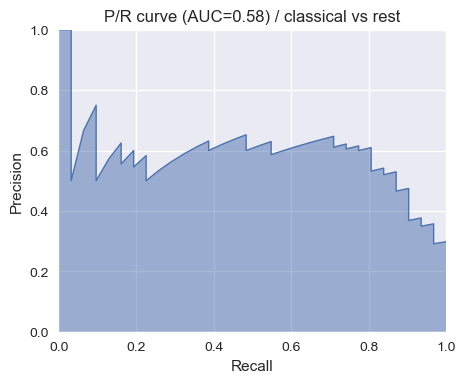

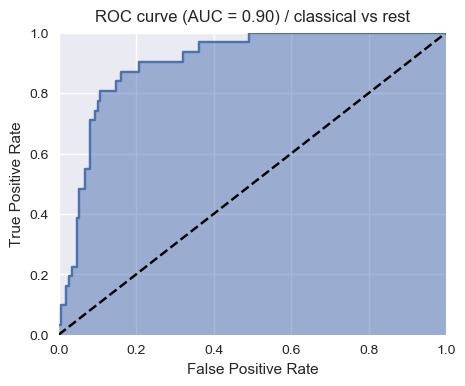

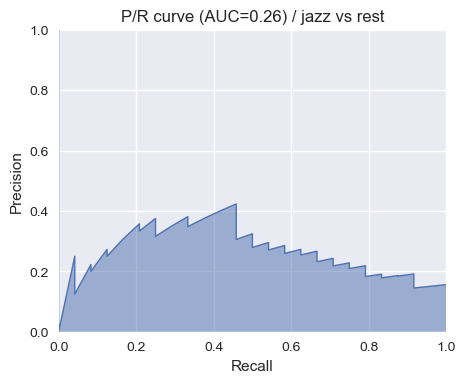

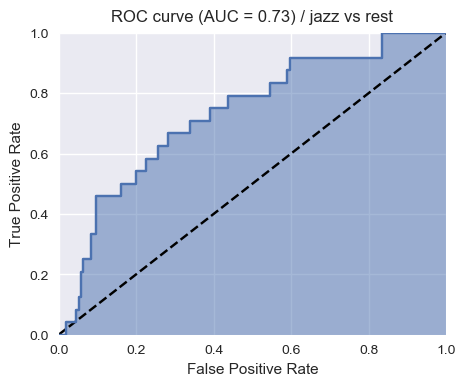

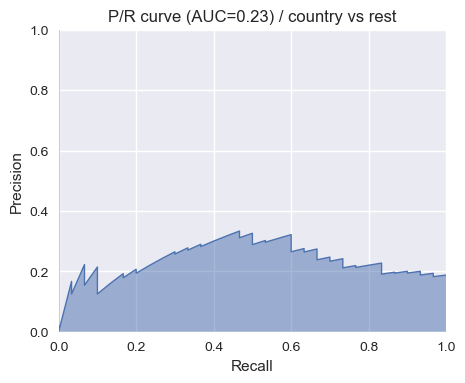

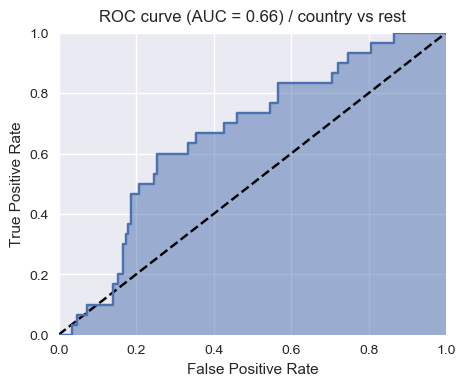

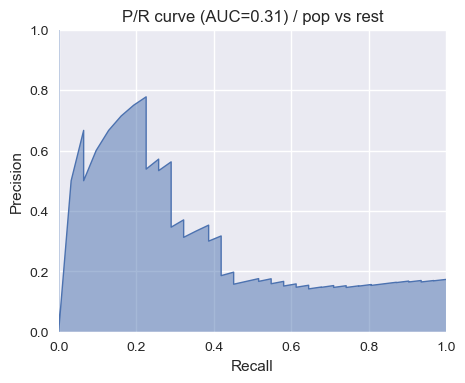

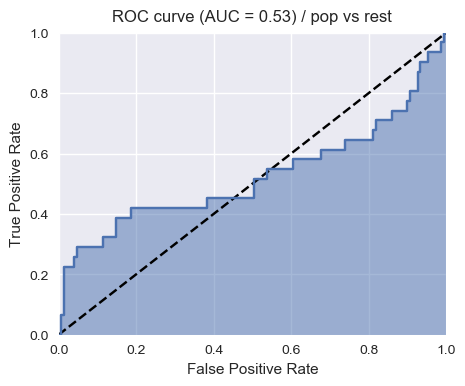

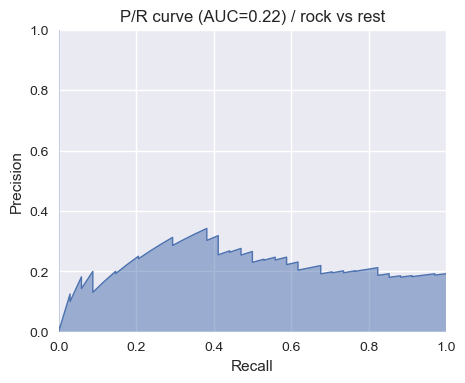

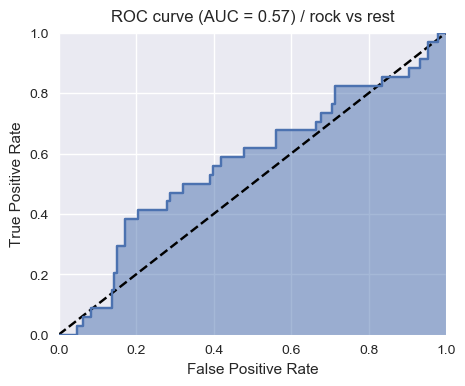

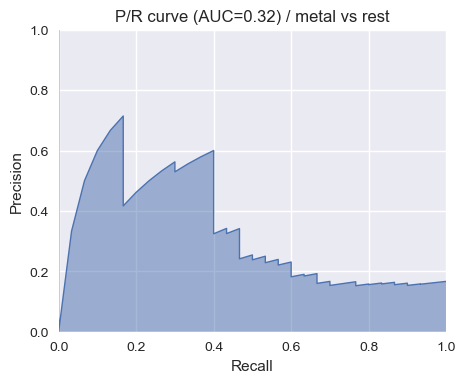

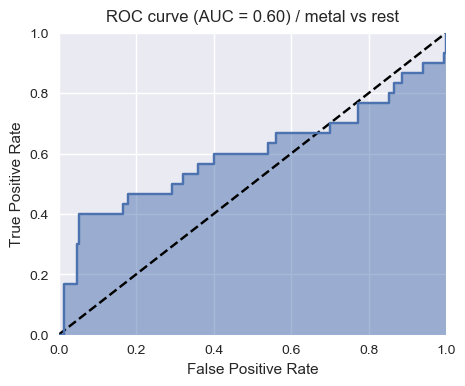

In [18]:
X, Y = read_fft(GENRES)

train_avg, test_avg, cms = train_model(create_model, X, Y, "Log Reg FFT", plot=5)

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


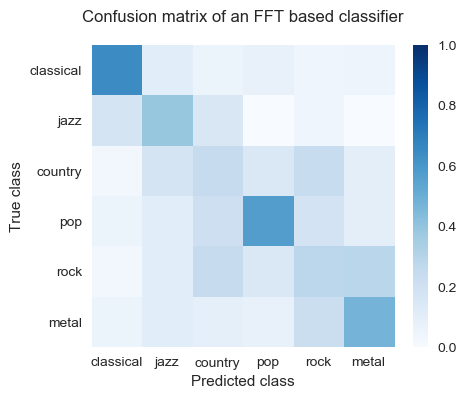

In [19]:
cm_avg = np.mean(cms, axis=0)
cm_norm = cm_avg / np.sum(cm_avg, axis=0)

plot_confusion_matrix(cm_norm, GENRES, "fft", "Confusion matrix of an FFT based classifier", 17)

# Improving classification performance with Mel Frequency Cepstral Coefficients

In [20]:
from python_speech_features import mfcc

fn = Path(GENRE_DIR) / 'jazz' / 'jazz.00000.wav'
sample_rate, X = scipy.io.wavfile.read(fn)
ceps = mfcc(X)
print(ceps.shape)

(4135, 13)


In [21]:
num_ceps = len(ceps)
np.mean(ceps[int(num_ceps*0.1):int(num_ceps*0.9)], axis=0)

array([ 16.43787597,   7.44767565, -13.48062285,  -7.49451887,
        -8.14466849,  -4.79407047,  -5.53101133,  -5.42776074,
        -8.69278344,  -6.41223865,  -3.01527269,  -2.75974429,  -3.61836327])

In [22]:
np.std(ceps[int(num_ceps*0.1):int(num_ceps*0.9)], axis=0)

array([  2.35924851,  12.06182075,   9.8524351 ,   6.17551375,
         6.88436778,   6.98513479,   8.53439104,   7.27414944,
         8.5409396 ,   8.99238561,   9.18711851,   8.83647839,   8.49855748])

## Generating MFCC features

In [23]:
def create_ceps(fn):
    sample_rate, X = scipy.io.wavfile.read(fn)
    np.save(Path(fn).with_suffix('.ceps'), mfcc(X))

for wav_fn in Path(GENRE_DIR).glob('**/*.wav'):
    print('Converting %s ...' % str(wav_fn))
    create_ceps(wav_fn)

Converting data\genres\blues\blues.00000.wav ...
Converting data\genres\blues\blues.00001.wav ...
Converting data\genres\blues\blues.00002.wav ...
Converting data\genres\blues\blues.00003.wav ...
Converting data\genres\blues\blues.00004.wav ...
Converting data\genres\blues\blues.00005.wav ...
Converting data\genres\blues\blues.00006.wav ...
Converting data\genres\blues\blues.00007.wav ...
Converting data\genres\blues\blues.00008.wav ...
Converting data\genres\blues\blues.00009.wav ...
Converting data\genres\blues\blues.00010.wav ...
Converting data\genres\blues\blues.00011.wav ...
Converting data\genres\blues\blues.00012.wav ...
Converting data\genres\blues\blues.00013.wav ...
Converting data\genres\blues\blues.00014.wav ...
Converting data\genres\blues\blues.00015.wav ...
Converting data\genres\blues\blues.00016.wav ...
Converting data\genres\blues\blues.00017.wav ...
Converting data\genres\blues\blues.00018.wav ...
Converting data\genres\blues\blues.00019.wav ...
Converting data\genr

Converting data\genres\classical\classical.00058.wav ...
Converting data\genres\classical\classical.00059.wav ...
Converting data\genres\classical\classical.00060.wav ...
Converting data\genres\classical\classical.00061.wav ...
Converting data\genres\classical\classical.00062.wav ...
Converting data\genres\classical\classical.00063.wav ...
Converting data\genres\classical\classical.00064.wav ...
Converting data\genres\classical\classical.00065.wav ...
Converting data\genres\classical\classical.00066.wav ...
Converting data\genres\classical\classical.00067.wav ...
Converting data\genres\classical\classical.00068.wav ...
Converting data\genres\classical\classical.00069.wav ...
Converting data\genres\classical\classical.00070.wav ...
Converting data\genres\classical\classical.00071.wav ...
Converting data\genres\classical\classical.00072.wav ...
Converting data\genres\classical\classical.00073.wav ...
Converting data\genres\classical\classical.00074.wav ...
Converting data\genres\classica

Converting data\genres\disco\disco.00011.wav ...
Converting data\genres\disco\disco.00012.wav ...
Converting data\genres\disco\disco.00013.wav ...
Converting data\genres\disco\disco.00014.wav ...
Converting data\genres\disco\disco.00015.wav ...
Converting data\genres\disco\disco.00016.wav ...
Converting data\genres\disco\disco.00017.wav ...
Converting data\genres\disco\disco.00018.wav ...
Converting data\genres\disco\disco.00019.wav ...
Converting data\genres\disco\disco.00020.wav ...
Converting data\genres\disco\disco.00021.wav ...
Converting data\genres\disco\disco.00022.wav ...
Converting data\genres\disco\disco.00023.wav ...
Converting data\genres\disco\disco.00024.wav ...
Converting data\genres\disco\disco.00025.wav ...
Converting data\genres\disco\disco.00026.wav ...
Converting data\genres\disco\disco.00027.wav ...
Converting data\genres\disco\disco.00028.wav ...
Converting data\genres\disco\disco.00029.wav ...
Converting data\genres\disco\disco.00030.wav ...
Converting data\genr

Converting data\genres\hiphop\hiphop.00076.wav ...
Converting data\genres\hiphop\hiphop.00077.wav ...
Converting data\genres\hiphop\hiphop.00078.wav ...
Converting data\genres\hiphop\hiphop.00079.wav ...
Converting data\genres\hiphop\hiphop.00080.wav ...
Converting data\genres\hiphop\hiphop.00081.wav ...
Converting data\genres\hiphop\hiphop.00082.wav ...
Converting data\genres\hiphop\hiphop.00083.wav ...
Converting data\genres\hiphop\hiphop.00084.wav ...
Converting data\genres\hiphop\hiphop.00085.wav ...
Converting data\genres\hiphop\hiphop.00086.wav ...
Converting data\genres\hiphop\hiphop.00087.wav ...
Converting data\genres\hiphop\hiphop.00088.wav ...
Converting data\genres\hiphop\hiphop.00089.wav ...
Converting data\genres\hiphop\hiphop.00090.wav ...
Converting data\genres\hiphop\hiphop.00091.wav ...
Converting data\genres\hiphop\hiphop.00092.wav ...
Converting data\genres\hiphop\hiphop.00093.wav ...
Converting data\genres\hiphop\hiphop.00094.wav ...
Converting data\genres\hiphop\h

Converting data\genres\metal\metal.00047.wav ...
Converting data\genres\metal\metal.00048.wav ...
Converting data\genres\metal\metal.00049.wav ...
Converting data\genres\metal\metal.00050.wav ...
Converting data\genres\metal\metal.00051.wav ...
Converting data\genres\metal\metal.00052.wav ...
Converting data\genres\metal\metal.00053.wav ...
Converting data\genres\metal\metal.00054.wav ...
Converting data\genres\metal\metal.00055.wav ...
Converting data\genres\metal\metal.00056.wav ...
Converting data\genres\metal\metal.00057.wav ...
Converting data\genres\metal\metal.00058.wav ...
Converting data\genres\metal\metal.00059.wav ...
Converting data\genres\metal\metal.00060.wav ...
Converting data\genres\metal\metal.00061.wav ...
Converting data\genres\metal\metal.00062.wav ...
Converting data\genres\metal\metal.00063.wav ...
Converting data\genres\metal\metal.00064.wav ...
Converting data\genres\metal\metal.00065.wav ...
Converting data\genres\metal\metal.00066.wav ...
Converting data\genr

Converting data\genres\reggae\reggae.00022.wav ...
Converting data\genres\reggae\reggae.00023.wav ...
Converting data\genres\reggae\reggae.00024.wav ...
Converting data\genres\reggae\reggae.00025.wav ...
Converting data\genres\reggae\reggae.00026.wav ...
Converting data\genres\reggae\reggae.00027.wav ...
Converting data\genres\reggae\reggae.00028.wav ...
Converting data\genres\reggae\reggae.00029.wav ...
Converting data\genres\reggae\reggae.00030.wav ...
Converting data\genres\reggae\reggae.00031.wav ...
Converting data\genres\reggae\reggae.00032.wav ...
Converting data\genres\reggae\reggae.00033.wav ...
Converting data\genres\reggae\reggae.00034.wav ...
Converting data\genres\reggae\reggae.00035.wav ...
Converting data\genres\reggae\reggae.00036.wav ...
Converting data\genres\reggae\reggae.00037.wav ...
Converting data\genres\reggae\reggae.00038.wav ...
Converting data\genres\reggae\reggae.00039.wav ...
Converting data\genres\reggae\reggae.00040.wav ...
Converting data\genres\reggae\r

Converting data\genres\rock\rock.00090.wav ...
Converting data\genres\rock\rock.00091.wav ...
Converting data\genres\rock\rock.00092.wav ...
Converting data\genres\rock\rock.00093.wav ...
Converting data\genres\rock\rock.00094.wav ...
Converting data\genres\rock\rock.00095.wav ...
Converting data\genres\rock\rock.00096.wav ...
Converting data\genres\rock\rock.00097.wav ...
Converting data\genres\rock\rock.00098.wav ...
Converting data\genres\rock\rock.00099.wav ...


In [24]:
def read_ceps(genre_list, base_dir=GENRE_DIR):
    X = []
    y = []
    for label, genre in enumerate(genre_list):
        genre_dir = Path(base_dir) / genre
        for fn in genre_dir.glob("*.ceps.npy"):
            ceps = np.load(fn)
            num_ceps = len(ceps)
            X.append(np.mean(ceps[int(num_ceps / 10):int(num_ceps * 9 / 10)], axis=0))
            y.append(label)

    return np.array(X), np.array(y)

## Training the MFCC-based classifier

No handles with labels found to put in legend.


Plotting classical
Plotting jazz


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Plotting country
Plotting pop


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Plotting rock


No handles with labels found to put in legend.


Plotting metal
0.672	0.000	0.676	0.226	


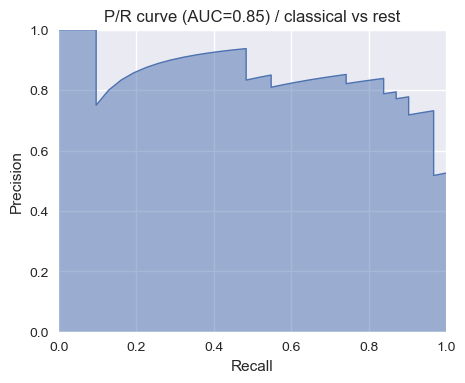

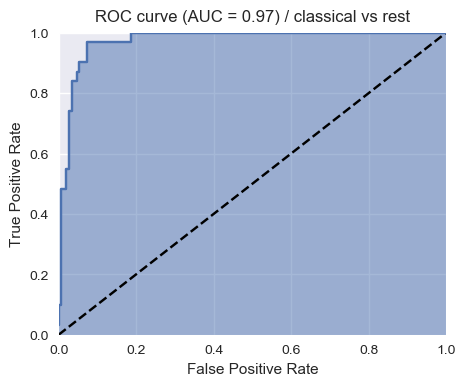

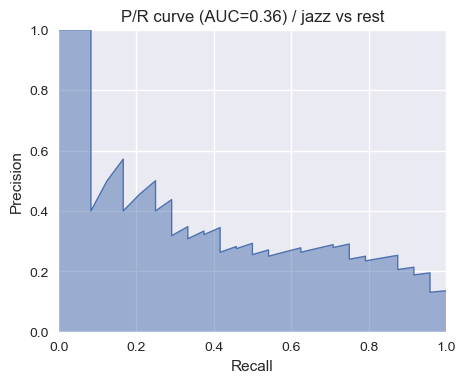

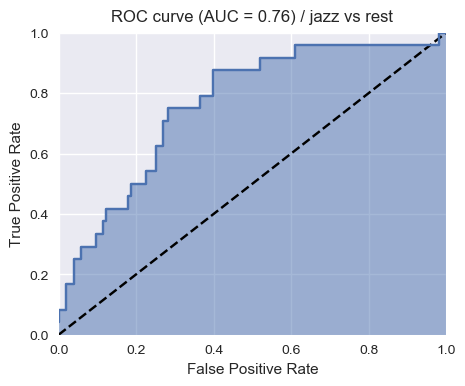

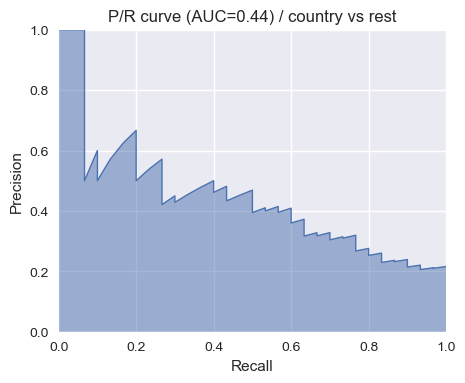

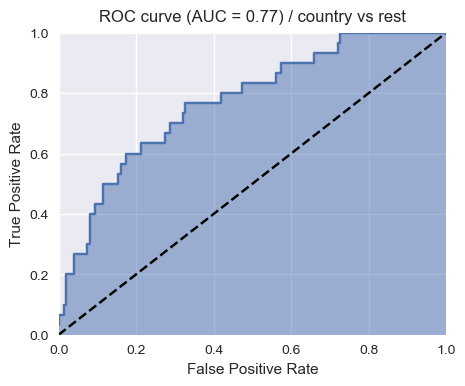

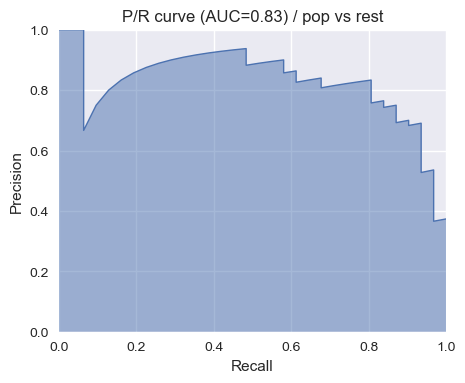

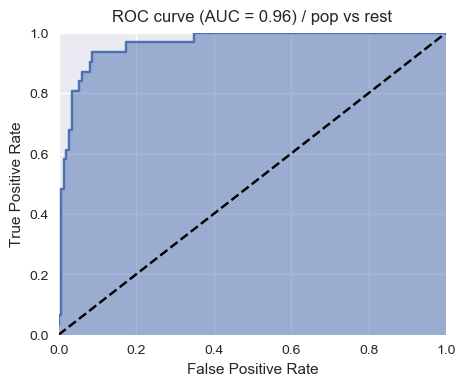

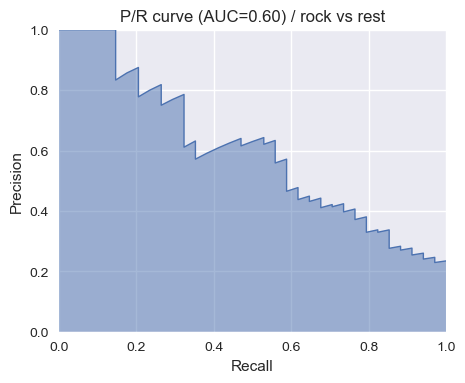

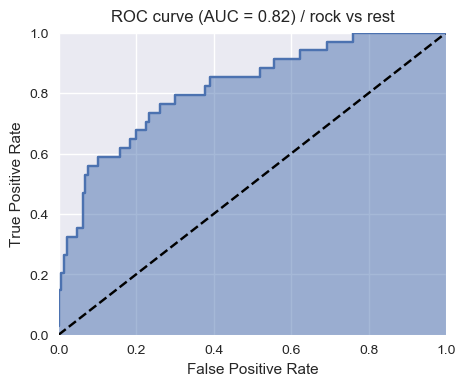

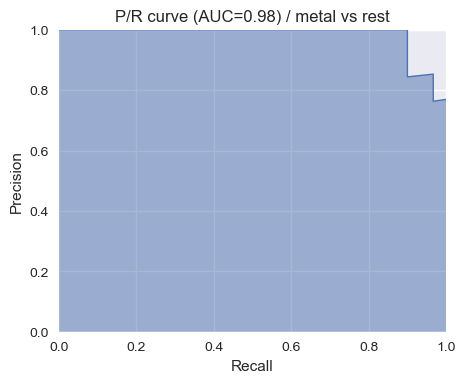

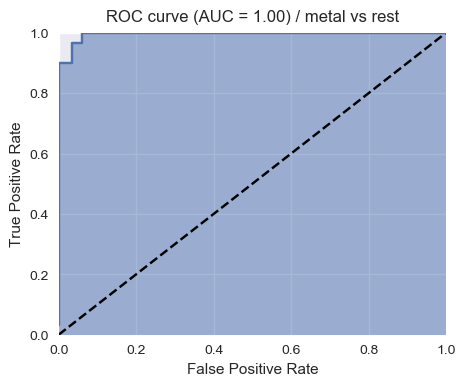

In [25]:
X, Y = read_ceps(GENRES)

train_avg, test_avg, cms = train_model(create_model, X, Y, "Log Reg CEPS", plot=18)

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


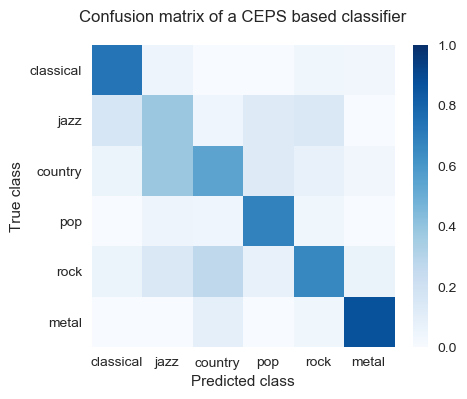

In [26]:
cm_avg = np.mean(cms, axis=0)
cm_norm = cm_avg / np.sum(cm_avg, axis=0)

plot_confusion_matrix(cm_norm, GENRES, "ceps","Confusion matrix of a CEPS based classifier", 19)

# Classification with Tensorflow

As the Fourier transform is a filter, which defines our features, we can also use CNN for the same kind of classification.

In [199]:
import tensorflow as tf
import numpy as np

n_epochs = 50
learning_rate = 0.01
batch_size = 128
step = 32
dropout_rate = 0.2

signal_size = 1000
signal_shape = [signal_size,1]

With only 600 songs, we don't have enough data for a neural network. But we don't need to train the network wth just 1000 samples, we can split each of them to "generate" more samples.

In [169]:
def read_wav(genre_list, multiplicity=1, base_dir=GENRE_DIR):
    X = []
    y = []
    for label, genre in enumerate(genre_list):
        genre_dir = Path(base_dir) / genre
        for fn in genre_dir.glob("*.wav"):
            sample_rate, new_X = scipy.io.wavfile.read(fn)
            for i in range(multiplicity):
                X.append(new_X[i*signal_size:(i+1)*signal_size])
                y.append(label)

    return np.array(X).reshape((-1, signal_size, 1)), np.array(y)

So we will get 20 excerpts from each song.

In [197]:
from sklearn.model_selection import train_test_split

X, Y = read_wav(GENRES, 20)
classes = len(GENRES)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=(1. / 6.))

We modify our CNN class a little bit to use 1D convolution, and we also customize the pool size, as we expect it to require to be bigger for our training.

In [152]:
class CNN():
    def __init__(
            self,
            signal_shape=[1000,1],
            dim_W1=64,
            dim_W2=32,
            dim_W3=16,
            classes=6,
            kernel_size=5,
            pool_size=16
            ):

        self.signal_shape = signal_shape

        self.dim_W1 = dim_W1
        self.dim_W2 = dim_W2
        self.dim_W3 = dim_W3
        self.classes = classes
        self.kernel_size = kernel_size
        self.pool_size = pool_size

    def build_model(self):
        image = tf.placeholder(tf.float32, [None]+self.signal_shape, name="signal")
        Y = tf.placeholder(tf.int64, [None], name="label")
        training = tf.placeholder(tf.bool, name="is_training")

        probabilities = self.discriminate(image, training)
        cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=probabilities))
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(probabilities, axis=1), Y), tf.float32), name="accuracy")

        return image, Y, cost, accuracy, probabilities, training

    def create_conv1d(self, input, filters, kernel_size, name):
        layer = tf.layers.conv1d(
                    inputs=input,
                    filters=filters,
                    kernel_size=kernel_size,
                    activation=tf.nn.leaky_relu,
                    name="Conv1d_" + name,
                    padding="same")
        return layer
    
    def create_maxpool(self, input, name):
        layer = tf.layers.max_pooling1d(
                    inputs=input,
                    pool_size=[self.pool_size],
                    strides=self.pool_size,
                    name="MaxPool_" + name)
        return layer

    def create_dropout(self, input, name, is_training):
        layer = tf.layers.dropout(
                    inputs=input,
                    rate=dropout_rate,
                    name="DropOut_" + name,
                    training=is_training)
        return layer

    def create_dense(self, input, units, name):
        layer = tf.layers.dense(
                inputs=input,
                units=units,
                name="Dense" + name,
                )
        layer = tf.layers.batch_normalization(
                inputs=layer,
                momentum=0,
                epsilon=1e-8,
                training=True,
                name="BatchNorm_" + name,
        )
        layer = tf.nn.leaky_relu(layer, name="LeakyRELU_" + name)
        return layer

    def discriminate(self, signal, training):

        h1 = self.create_conv1d(signal, self.dim_W3, self.kernel_size, "Layer1")
        h1 = self.create_maxpool(h1, "Layer1")

        h2 = self.create_conv1d(h1, self.dim_W2, self.kernel_size, "Layer2")
        h2 = self.create_maxpool(h2, "Layer2")
        h2 = tf.reshape(h2, (-1, self.dim_W2 * h2.shape[1]))

        h3 = self.create_dense(h2, self.dim_W1, "Layer3")
        h3 = self.create_dropout(h3, "Layer3", training)
        
        h4 = self.create_dense(h3, self.classes, "Layer4")
        return h4

Let's also create a BaseEstimator subclass to use GridSearchCV to find the optimal set of parameters.

In [191]:
tf.reset_default_graph()

from sklearn.base import BaseEstimator

class Classifier(BaseEstimator):
    def __init__(self,
            signal_shape=[1000,1],
            dim_W1=64,
            dim_W2=32,
            dim_W3=16,
            classes=6,
            kernel_size=5,
            pool_size=16):
        self.signal_shape=signal_shape
        self.dim_W1=dim_W1
        self.dim_W2=dim_W2
        self.dim_W3=dim_W3
        self.classes=classes
        self.kernel_size=kernel_size
        self.pool_size=pool_size

    def fit(self, X, y):
        tf.reset_default_graph()

        print("Fitting (W1=%i) (W2=%i) (W3=%i) (kernel=%i) (pool=%i)"
              % (self.dim_W1, self.dim_W2, self.dim_W3, self.kernel_size, self.pool_size))
        
        cnn_model = CNN(
                signal_shape=self.signal_shape,
                dim_W1=self.dim_W1,
                dim_W2=self.dim_W2,
                dim_W3=self.dim_W3,
                classes=self.classes,
                kernel_size=self.kernel_size,
                pool_size=self.pool_size
                )

        signal_tf, Y_tf, cost_tf, accuracy_tf, output_tf, training_tf = cnn_model.build_model()
        train_step = tf.train.AdamOptimizer(learning_rate, beta1=0.5).minimize(cost_tf)

        saver = tf.train.Saver()
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for epoch in range(n_epochs):
                permut = np.random.permutation(len(X_train))
                for j in range(0, len(X_train), batch_size):
                    batch = permut[j:j+batch_size]
                    Xs = X_train[batch]
                    Ys = Y_train[batch]

                    sess.run(train_step,
                            feed_dict={
                                training_tf: True,
                                Y_tf: Ys,
                                signal_tf: Xs
                                })
            saver.save(sess, './classifier')
        return self
    
    def predict(self, X):
        tf.reset_default_graph()
        new_saver = tf.train.import_meta_graph("classifier.meta")  
        with tf.Session() as sess:  
            new_saver.restore(sess, tf.train.latest_checkpoint('./'))

            graph = tf.get_default_graph()
            training_tf = graph.get_tensor_by_name('is_training:0')
            signal_tf = graph.get_tensor_by_name('signal:0')
            output_tf = graph.get_tensor_by_name('LeakyRELU_Layer4/Maximum:0')
    
            predict = sess.run(output_tf,
                            feed_dict={
                                training_tf: False,
                                signal_tf: X
                                })
            return np.argmax(predict, axis=1)

We can now create a grid of parameters to explore. Be aware that this will take a lot of time!

In [200]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

param_grid = {
    "dim_W1": [4, 8, 16],
    "dim_W2": [4, 8, 16],
    "dim_W3": [4, 8, 16],
    "kernel_size":[7, 11, 15],
    "pool_size":[8, 12, 16],
}

cv = GridSearchCV(Classifier(), param_grid, scoring=make_scorer(accuracy_score), cv=6)

cv.fit(X, Y)
print(cv.best_params_)

Fitting (W1=4) (W2=4) (W3=4) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=4) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=4) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=4) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=4) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=4) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=4) (kernel=7) (pool=

INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=4) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=4) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=8) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=8) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=8) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=8) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from 

INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=8) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=8) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=8) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=8) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=8) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=16) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameter

INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=16) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=16) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=16) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=16) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=16) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=4) (W3=16) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring pa

Fitting (W1=4) (W2=8) (W3=4) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=4) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=4) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=4) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=4) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=4) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=4) (kern

INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=8) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=8) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=8) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=8) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=8) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=8) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameter

INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=16) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=16) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=16) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=16) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=16) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=8) (W3=16) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parame

INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=4) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=4) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=4) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=4) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=4) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=4) (kernel=15) (pool=8)
INFO:tensorflow:Restoring paramet

INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=8) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=8) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=8) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=8) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=8) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=8) (kernel=15) (pool=8)
INFO:tensorflow:Restoring para

Fitting (W1=4) (W2=16) (W3=16) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=16) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=16) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=16) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=16) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16) (W3=16) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=4) (W2=16)

Fitting (W1=8) (W2=4) (W3=4) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=4) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=4) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=4) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=4) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=4) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=4) (kern

INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=8) (kernel=11) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=8) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=8) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=8) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=8) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=8) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameter

INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=16) (kernel=11) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=16) (kernel=11) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=16) (kernel=11) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=16) (kernel=11) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=16) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=4) (W3=16) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parame

INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=4) (kernel=7) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=4) (kernel=11) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=4) (kernel=11) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=4) (kernel=11) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=4) (kernel=11) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=4) (kernel=11) (pool=8)
INFO:tensorflow:Restoring parameters fro

INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=8) (kernel=7) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=8) (kernel=7) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=8) (kernel=7) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=8) (kernel=7) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=8) (kernel=11) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=8) (kernel=11) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters fro

Fitting (W1=8) (W2=8) (W3=16) (kernel=7) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=16) (kernel=7) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=16) (kernel=7) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=16) (kernel=7) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=16) (kernel=7) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=16) (kernel=7) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=8) (W3=16) (ker

Fitting (W1=8) (W2=16) (W3=4) (kernel=7) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=4) (kernel=7) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=4) (kernel=7) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=4) (kernel=7) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=4) (kernel=7) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=4) (kernel=7) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=4) (ker

Fitting (W1=8) (W2=16) (W3=8) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=8) (kernel=7) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=8) (kernel=7) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=8) (kernel=7) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=8) (kernel=7) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=8) (kernel=7) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=8) (kern

Fitting (W1=8) (W2=16) (W3=16) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=16) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=16) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=16) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=16) (kernel=7) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=16) (kernel=7) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=16) (

INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=8) (W2=16) (W3=16) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=4) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=4) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=4) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=4) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=4) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters 

INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=4) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=4) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=4) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=4) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=8) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=8) (kernel=7) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parame

INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=8) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=8) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=8) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=8) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=8) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=8) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring pa

INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=16) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=16) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=16) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=16) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=16) (kernel=15) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=4) (W3=16) (kernel=15) (pool=16)
INFO:tensorflow:Restor

INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=4) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=4) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=4) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=4) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=4) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=4) (kernel=15) (pool=12)
INFO:tensorflow:Restoring par

INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=8) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=8) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=8) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=8) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=8) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=8) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parame

Fitting (W1=16) (W2=8) (W3=16) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=16) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=16) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=16) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=16) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3=16) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=8) (W3

INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=4) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=4) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=4) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=4) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=4) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=4) (kernel=15) (pool=8)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restori

INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=8) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=8) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=8) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=8) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=8) (kernel=11) (pool=16)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=8) (kernel=11) (pool=16)
INFO:tensorflow:Restor

INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=16) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=16) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=16) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=16) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=16) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier
Fitting (W1=16) (W2=16) (W3=16) (kernel=11) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:

And now let's use these best parameters and check the results.

Fitting (W1=4) (W2=4) (W3=16) (kernel=15) (pool=12)
INFO:tensorflow:Restoring parameters from ./classifier
INFO:tensorflow:Restoring parameters from ./classifier


/home/matthieu/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/matthieu/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[[261  61   8   3   8   5]
 [111 105  33  58  11   8]
 [ 35  81  76  90  41  14]
 [ 12  35  22 257   3   1]
 [ 16  36  66  79  65  69]
 [  9   4  32  12  50 223]]


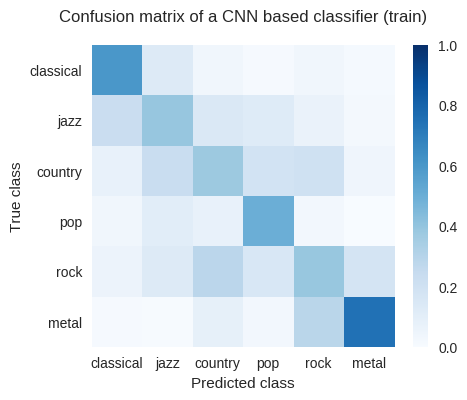

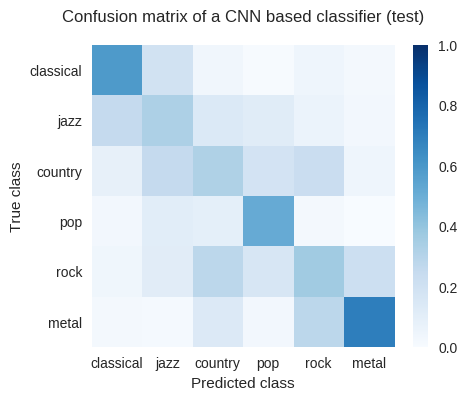

In [201]:
clf = Classifier(**cv.best_params_)
clf.fit(X_train, Y_train)

Y_train_predict = clf.predict(X_train)
Y_test_predict = clf.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, Y_train_predict)
plot_confusion_matrix(cm / np.sum(cm, axis=0), GENRES, "CNN","Confusion matrix of a CNN based classifier (train)", 20)
cm = confusion_matrix(Y_test, Y_test_predict)
plot_confusion_matrix(cm / np.sum(cm, axis=0), GENRES, "CNN","Confusion matrix of a CNN based classifier (test)", 21)